In [1]:
import os.path
fileName = os.path.join('/home/rafael/', 'millionsong.txt')

numPartitions = 2
rawData = sc.textFile(fileName, numPartitions)

In [2]:
numPoints = rawData.count()
print(numPoints)
samplePoints = rawData.take(5)
print(samplePoints)

6724
['2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817', '2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624', '2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818', '2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173', '2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946']


In [3]:
assert numPoints==6724, 'incorrect value for numPoints'
print("OK")
assert len(samplePoints)==5, 'incorrect length for samplePoints'
print("OK")

OK
OK


In [7]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

In [8]:
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    Point = str.split(line, ',')
    return LabeledPoint(Point[0], Point[1:])

parsedSamplePoints = list(map(parsePoint, samplePoints))
firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print(firstPointFeatures, firstPointLabel)

d = len(firstPointFeatures)
print(d)

[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0
12


In [9]:
assert isinstance(firstPointLabel, float), 'label must be a float'
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
assert np.allclose(expectedX0, firstPointFeatures, 1e-4, 1e-4), 'incorrect features for firstPointFeatures'
assert np.allclose(2001.0, firstPointLabel), 'incorrect label for firstPointLabel'
assert d == 12, 'incorrect number of features'
print("OK")

OK


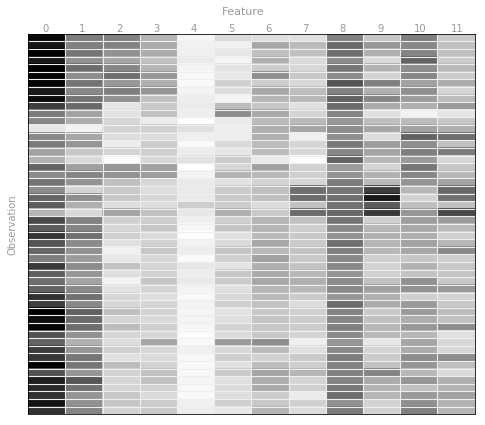

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

sampleMorePoints = rawData.take(50)

parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = list(map(lambda lp: lp.features.toArray(), parsedSampleMorePoints))

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
pass

In [15]:
parsedDataInit = rawData.map(lambda x:parsePoint(x))
onlyLabels = parsedDataInit.map(lambda x:x.label)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print (maxYear, minYear)

2011.0 1922.0


In [16]:
assert len(parsedDataInit.take(1)[0].features)==12, 'unexpected number of features in sample point'
sumFeatTwo = parsedDataInit.map(lambda lp: lp.features[2]).sum()
assert np.allclose(sumFeatTwo, 3158.96224351), 'parsedDataInit has unexpected values'
yearRange = maxYear - minYear
assert yearRange == 89, 'incorrect range for minYear to maxYear'
print("OK")

OK


In [18]:
parsedData = parsedDataInit.map(lambda x:LabeledPoint(x.label-minYear,x.features))

print (type(parsedData.take(1)[0]))
print ('\n{0}'.format(parsedData.take(1)))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]


In [19]:
oldSampleFeatures = parsedDataInit.take(1)[0].features
newSampleFeatures = parsedData.take(1)[0].features
assert np.allclose(oldSampleFeatures, newSampleFeatures), 'new features do not match old features'
sumFeatTwo = parsedData.map(lambda lp: lp.features[2]).sum()
assert np.allclose(sumFeatTwo, 3158.96224351), 'parsedData has unexpected values'
minYearNew = parsedData.map(lambda lp: lp.label).min()
maxYearNew = parsedData.map(lambda lp: lp.label).max()
assert minYearNew == 0, 'incorrect min year in shifted data'
assert maxYearNew == 89, 'incorrect max year in shifted data'
print("OK")

OK


In [20]:
weights = [.8, .1, .1]
seed = 42
parsedTrainData , parsedValData, parsedTestData = parsedData.randomSplit(weights=weights, seed=seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTrainData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print(nTrain, nVal, nTest, nTrain + nVal + nTest)
print(parsedData.count())

5359 678 687 6724
6724


In [21]:
assert parsedTrainData.getNumPartitions() == numPartitions, 'parsedTrainData has wrong number of partitions'
assert parsedValData.getNumPartitions() == numPartitions, 'parsedValData has wrong number of partitions'
assert parsedTestData.getNumPartitions() == numPartitions,'parsedTestData has wrong number of partitions'
assert len(parsedTrainData.take(1)[0].features) == 12, 'parsedTrainData has wrong number of features'
sumFeatTwo = (parsedTrainData
              .map(lambda lp: lp.features[2])
              .sum())
sumFeatThree = (parsedValData
                .map(lambda lp: lp.features[3])
                .reduce(lambda x, y: x + y))
sumFeatFour = (parsedTestData
               .map(lambda lp: lp.features[4])
               .reduce(lambda x, y: x + y))
assert np.allclose([sumFeatTwo, sumFeatThree, sumFeatFour],2526.87757656, 297.340394298, 184.235876654), 'parsed Train, Val, Test data has unexpected values'
assert nTrain + nVal + nTest == 6724, 'unexpected Train, Val, Test data set size'
assert nTrain == 5359, 'unexpected value for nTrain'
assert nVal == 678, 'unexpected value for nVal'
assert nTest == 687, 'unexpected value for nTest'
print("OK")

OK


In [37]:
averageTrainYear = (parsedTrainData
                    .map(lambda x:x.label)
                    .mean()
                   )
print(averageTrainYear)


53.67923119985066


In [38]:
assert np.allclose(averageTrainYear, 53.6792311), 'incorrect value for averageTrainYear'
print("OK")

OK


In [85]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (label - prediction)**2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return ((labelsAndPreds.map(lambda x:squaredError(x[0],x[1])).sum())/labelsAndPreds.count())**(1/2)

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print (exampleRMSE)

1.2909944487358056


In [86]:
assert np.allclose(squaredError(3, 1), 4.), 'incorrect definition of squaredError'
assert np.allclose(exampleRMSE, 1.29099444874), 'incorrect value for exampleRMSE'
print("OK")

OK


In [97]:
labelsAndPredsTrain = parsedTrainData.map(lambda x:(x.label, averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredVal = parsedValData.map(lambda x:(x.label, averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredVal)

labelsAndPredsTest = parsedTestData.map(lambda x:(x.label, averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print ('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print ('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 21.506
Baseline Validation RMSE = 20.877
Baseline Test RMSE = 21.260


In [98]:
assert np.allclose([rmseTrainBase, rmseValBase, rmseTestBase],[21.506125957738682, 20.877445428452468, 21.260493955081916]), 'incorrect RMSE value'
print("OK")

OK


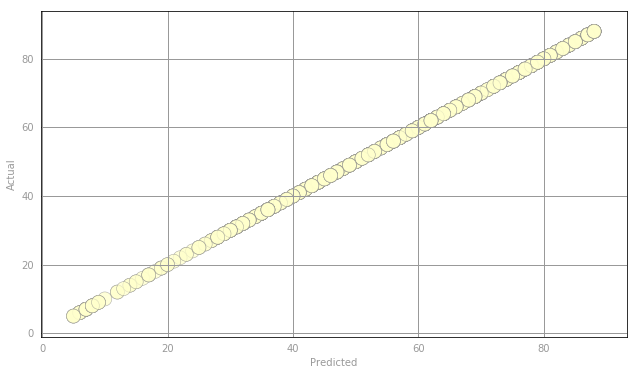

In [99]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
pass

(Text(0.5,0,'Predicted'), Text(0,0.5,'Actual'))

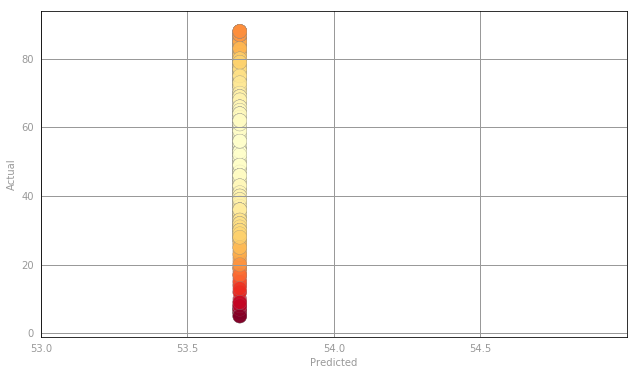

In [100]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, averageTrainYear))
                   .map(lambda lp: squaredError(lp[0], lp[1]))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

In [101]:
from pyspark.mllib.linalg import DenseVector

In [174]:
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return DenseVector((weights.transpose().dot(DenseVector(lp.features))) - lp.label) * DenseVector(lp.features)

exampleW = DenseVector([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])

summandOne = gradientSummand(exampleW, exampleLP)
print (summandOne)

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print (summandTwo)

[18.0,6.0,24.0]
[1.7303999999999995,-5.191199999999999,-2.5955999999999997]


In [175]:
assert np.allclose(summandOne, [18., 6., 24.]), 'incorrect value for summandOne'
assert np.allclose(summandTwo, [1.7304,-5.1912,-2.5956]), 'incorrect value for summandTwo'
print("OK")

OK


In [176]:
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return observation.label, (weights * observation.features).sum()

weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print (labelsAndPredsExample.collect())

[(2.0, 1.75), (1.5, 1.25)]


In [177]:
assert labelsAndPredsExample.collect() == [(2.0, 1.75), (1.5, 1.25)], 'incorrect definition for getLabeledPredictions'
print("OK")

OK


In [234]:
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda x:getLabeledPrediction(w, x))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda x:gradientSummand(w, x)).reduce(lambda x,y:x+y)

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i*gradient
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print (exampleData.take(2))
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print (exampleWeights)

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968]), LabeledPoint(79.0, [0.854411946129,0.604124786151,0.593634078776])]
[48.20389904 34.53243006 30.60284959]


In [235]:
expectedOutput = [48.20389904,  34.53243006, 30.60284959]
assert np.allclose(exampleWeights, expectedOutput), 'value of exampleWeights is incorrect'
expectedError = [79.72766145,  33.64762907,   9.46281696,   9.45486926,   9.44889147]
assert np.allclose(exampleErrorTrain, expectedError),'value of exampleErrorTrain is incorrect'
print("OK")

OK


In [237]:
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData, numIters)

labelsAndPreds = parsedValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseValLR0 = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase, rmseValLR0))

Validation RMSE:
	Baseline = 20.877
	LR0 = 18.253


In [238]:
expectedOutput = [ 22.64370481,  20.1815662,   -0.21620107,   8.53259099,   5.94821844,
  -4.50349235,  15.51511703,   3.88802901,   9.79146177,   5.74357056,
  11.19512589,   3.60554264]
assert np.allclose(weightsLR0, expectedOutput), 'incorrect value for weightsLR0'
print("OK")

OK


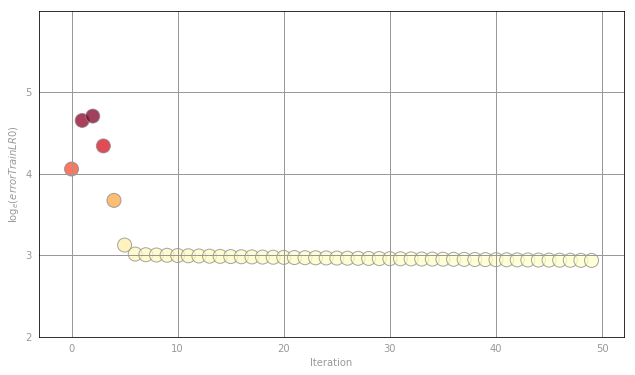

In [239]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(list(range(0, numIters)), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

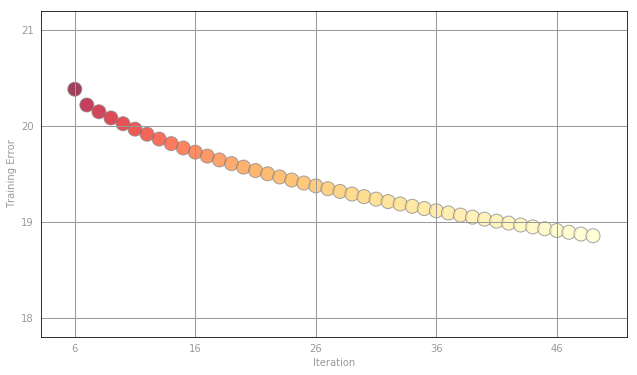

In [240]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass